# Solve Dependencies

In [6]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import typing as tp
from PIL import Image

from torch.utils.data import DataLoader
import torchvision.models as models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pytorch_lightning as pl

pl.seed_everything(seed=42, workers=True)


Seed set to 42


42

# First, test with Baseline Model

## Create CSV File to Store Filenames and Labels
<a id="create-labels-csv-file"></a>


In [2]:
def create_label_csv(root_dir, output_csv):
    # Initialize an empty list to hold the data
    data = []

    # Define class names and their corresponding labels
    class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

    # Loop through each class folder
    for class_name in class_names:
        class_folder = os.path.join(root_dir, class_name)
        
        # Check if the class folder exists
        if not os.path.exists(class_folder):
            print(f"Warning: {class_folder} does not exist.")
            continue
        
        # Loop through all files in the class folder
        for filename in os.listdir(class_folder):
            if filename.endswith(('.png', '.jpg', '.jpeg')):  # Add any other image formats if needed
                # Create a tuple of (filename, label)
                data.append((class_name+'/'+filename, class_name))
    
    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=['filename', 'label'])
    
    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)
    print(f"CSV file created at: {output_csv}")

In [3]:
# Specify the directory and the output CSV file name
test_root_directory = '../dataset/test'  # Path to the train directory
test_output_csv_file = '../dataset/test.csv'  # Output CSV file name

# create_label_csv(test_root_directory, test_output_csv_file)

## Define classes for DataSet and DataLoader

In [4]:
class_map = {
    'CNV': 0,
    'DME': 1,
    'DRUSEN': 2,
    'NORMAL': 3
}

class OCTDataset(Dataset):
    def __init__(
        self,
        images_dir: str,
        labels_csv: str,
        indices: tp.Optional[tp.List[int]] = None,
        transform: tp.Optional[transforms.Compose] = None,
    ):
        self.images_dir = images_dir
        self.labels_csv = labels_csv
        self.transform = transform
        
        # Carrega o arquivo CSV e filtra pelos índices, se fornecidos
        labels_df = pd.read_csv(labels_csv)
        
        if indices is not None:
            # Seleciona apenas os índices fornecidos
            labels_df = labels_df.iloc[indices].reset_index(drop=True)
        
        # Armazena os caminhos das imagens e rótulos como listas
        self.image_paths = [os.path.join(images_dir, fname) for fname in labels_df['filename']]
        self.labels = labels_df['label'].tolist()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Carrega a imagem a partir do caminho
        image = Image.open(self.image_paths[idx]).convert("L")
        
        # Aplica as transformações, se existirem
        if self.transform:
            image = self.transform(image)
        
        # Retorna a imagem e o rótulo
        label = torch.tensor(class_map[self.labels[idx]])
        return image, label

### Instantiate DataLoader

In [5]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for SqueezeNet
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(           # Normalize the images
        mean=[0.5],
        std=[0.5]
    )
])

test_dataset = OCTDataset(
    images_dir=test_root_directory,
    labels_csv=test_output_csv_file,
    transform=transform
)

# Avaliação do modelo no conjunto de teste
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## Use DataLoader to evaluate model with tests data

In [17]:
# Define o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Caminho para salvar checkpoints
CHECKPOINT_PATH = "checkpoints"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

def load_checkpoint(filename, model, optimizer):
    """Carrega um checkpoint."""
    if os.path.isfile(filename):
        checkpoint = torch.load(filename, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        epoch = checkpoint["epoch"]
        losses = checkpoint["losses"]
        accuracies = checkpoint["accuracies"]
        print(f"Checkpoint carregado de {filename}, retomando do epoch {epoch+1}")
        return epoch, losses, accuracies
    else:
        print(f"Nenhum checkpoint encontrado em {filename}, iniciando do zero.")
        return 0, {"train": [], "val": []}, {"train": [], "val": []}

def baseline_work(lr, num_epochs):
    
    # Carrega o modelo pré-treinado SqueezeNet
    model = models.squeezenet1_1(pretrained=True)

    # Modifica a primeira camada para aceitar imagens de um canal
    model.features[0] = nn.Conv2d(
        in_channels=1,  # Aceitar 1 canal
        out_channels=64,
        kernel_size=(3, 3),
        stride=(2, 2),
        padding=(1, 1),
        bias=False
    )

    # Ajusta o classificador para 4 classes
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Conv2d(512, 4, kernel_size=(1, 1)),
        nn.ReLU(inplace=True),
        nn.AdaptiveAvgPool2d((1, 1))
    )

    # Movendo para o dispositivo
    model = model.to(device)

    # Define o critério e otimizador
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr)

    # Checkpoints
    checkpoint_file = os.path.join(CHECKPOINT_PATH, "last_checkpoint.pth")
    start_epoch, _, _ = load_checkpoint(checkpoint_file, model, optimizer)
    
    # Testes
    for epoch in range(start_epoch, start_epoch + num_epochs):
        print("epoch: ", epoch)

        # Modo de validação (teste)
        model.eval()
        running_loss_test = 0
        correct_test = 0
        total_test = 0

        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss_test += loss.item() * images.size(0)

                # Cálculo da acurácia de validação
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
                
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = running_loss_test / len(test_loader.dataset)
        test_accuracy = 100 * correct_test / total_test
        # losses["test"].append(test_loss)
        # accuracies["test"].append(test_accuracy)

        # Exibe métricas por época
        # print(f"Época {epoch+1}/{num_epochs}, Loss Treino: {train_loss}, Acurácia Treino: {train_accuracy}")
        print(f"Época {epoch+1}/{num_epochs}, Loss Teste: {test_loss}, Acurácia Teste: {test_accuracy}")
    
    return test_loss, test_accuracy, all_predictions, all_labels

test_loss, test_accuracy, test_predictions, test_labels = baseline_work(lr=1e-5, num_epochs=1)

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\User\AppData\Local\Temp\ipykernel_12644\1107448827.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https

Checkpoint carregado de checkpoints\last_checkpoint.pth, retomando do epoch 30
epoch:  29
Época 30/1, Loss Teste: 0.30352666398083905, Acurácia Teste: 89.20698801792737


### Visualize results in a confusion matrix

[[3325   47   79   15]
 [  83  931   27  110]
 [ 317   46  596  113]
 [  21  137  185 4901]]


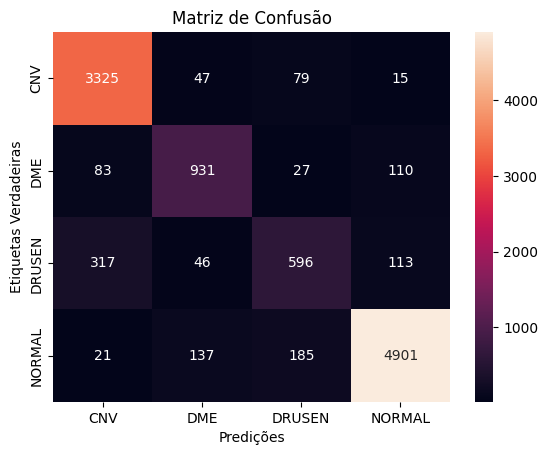

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(test_predictions, test_labels)
print(confusion_mat)

# Criando um heatmap da matriz de confusão
sns.heatmap(confusion_mat, annot=True, fmt="d", xticklabels=class_map.keys(), yticklabels=class_map.keys())
plt.xlabel("Predições")
plt.ylabel("Etiquetas Verdadeiras")
plt.title("Matriz de Confusão")
plt.show()

# Second, test with DownStream Model

### Define SimCLR class

In [7]:
class SimCLR(pl.LightningModule):
    '''
    SimCLR model with a SqueezeNet backbone.

    Args:
        hidden_dim: The dimension of the hidden layer in the projection head. 
            Number of units in the hidden layer; we'll use 25% of the number of classes.
        lr: The learning rate for the optimizer.
        temperature: The temperature parameter for the contrastive loss.
        weight_decay: The weight decay for the optimizer.
        max_epochs: The maximum number of epochs for training.

    '''

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'

        # Usando pesos pré-treinados do ImageNet
        self.convnet = torchvision.models.squeezenet1_1(weights=torchvision.models.SqueezeNet1_1_Weights.DEFAULT)

        # Copiar os pesos da primeira camada convolucional do modelo pré-treinado
        pretrained_weights = self.convnet.features[0].weight

        # Substituir a primeira camada convolucional para aceitar imagens em escala de cinza
        self.convnet.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))

        # Use mean across the input channels (to average RGB weights)
        self.convnet.features[0].weight.data = pretrained_weights.mean(dim=1, keepdim=True)

        # Replace the classifier head of SqueezeNet.
        # We add an extra fully connected layer to form the projection head.
        self.convnet.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Ensures output size is 1x1 before the final layers.
            nn.Flatten(),             # Flattens the tensor for the linear layer.
            nn.Linear(512, 4 * hidden_dim),  # First fully connected layer with output 4 * hidden_dim.
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Second fully connected layer with output hidden_dim.
        )


    def configure_optimizers(self):
        '''
        Configures the optimizer and the learning rate scheduler.
        '''

        # Adam optimizer.
        #
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay)
        
        # Uses the cosine annealing schedule to set the learning rate (eta).
        #
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.hparams.max_epochs,
            eta_min=self.hparams.lr/50)
        
        return [optimizer], [lr_scheduler]
    

    def forward(self, batch):
        imgs, _ = batch

        # Check if the batch is a list or tuple; if so, concatenate the tensors
        #
        if isinstance(imgs, (list, tuple)):
            imgs = torch.cat(imgs, dim=0)

        # Extract features from the backbone
        #
        feats = self.convnet.features(imgs)  

        # Flatten the feature map
        #
        feats = torch.flatten(feats, start_dim=1)

        return feats


    def info_nce_loss(self, batch, mode='train'):
        '''
        This method defines the InfoNCE loss (SimCLR's paper loss) used in the pretext task learning.
        
        Computes the InfoNCE loss for the batch of images.

        Args:
            batch: The batch of images.
            mode: The mode of the model (train or val). [Log purposes]

        Returns:
            The InfoNCE loss for the batch of images.
        '''

        # _ is a special variable that stores the last value in batch.
        imgs, _ = batch

        # Concat images in the zero dimension (rows).
        if isinstance(imgs, (list, tuple)):
            imgs = torch.cat(imgs, dim=0)

        # Encode all images using the representation extraction function
        # 
        # i.e. pass each image through the same architecture.
        feats = self.convnet.features(imgs)  # Get features before projection head

        # Flatten the feature map to match input dimensions for the classifier
        feats = feats.view(feats.size(0), -1)
        
        # Calculate cosine similarity. Similarity is computed along the
        # last dimension of the tensor (that's what dim=-1 means, like in Python's lists)
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)

        # Mask out cosine similarity to itself
        # (to avoid to compute similarity against itself):
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)

        # Find positive example -> batch_size//2 away from the original example
        # // is the integer division operator in Python:
        #
        # (Sligthly different from the paper, where they are indices 2k-1 and 2k)
        #
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)

        # Computing the InfoNCE loss:
        #
        cos_sim = cos_sim / self.hparams.temperature        
        result = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        result = result.mean()

        # Logging loss:
        #
        self.log(mode+'_loss', result, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        # Getting ranking position of positive example (i.e., we see how far it is
        # when compared with the negative examples). Useful to compute top-k metrics.
        #
        comb_sim = torch.cat([cos_sim[pos_mask][:,None], 
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

        # Logging ranking metrics:
        #
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean(), on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return result


    # Training step method.
    #
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')


    # Validation step method.
    #
    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

print("SimCLR model sucessfully implemented.")

SimCLR model sucessfully implemented.


### Define SqueezeNetDownstream class

In [14]:
class SqueezeNetDownstream(pl.LightningModule):
    '''
    Simple baseline model using SqueezeNet for classification.
    Changes: Input channels from 3 to 1 and output size to match the number of labels.
    '''

    def __init__(self, hidden_dim, lr, weight_decay, max_epochs=500, num_classes=4):
        super().__init__()
        self.save_hyperparameters()

        # Load pre-trained SqueezeNet and adjust the input and output layers
        self.convnet = torchvision.models.squeezenet1_1(weights=None)

        # Adjust input layer for grayscale images
        self.convnet.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=1)

        # Adjust classifier for the correct number of classes
        self.convnet.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Ensures output size is 1x1 before the linear layer
            nn.Flatten(),             # Flattens the tensor
            nn.Linear(512, num_classes)  # Final classification layer
        )


    def configure_optimizers(self):
        '''
        Configures the optimizer and the learning rate scheduler.
        '''

        # Adam optimizer.
        #
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay)
        
        # Uses the cosine annealing schedule to set the learning rate (eta).
        # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
        #
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.hparams.max_epochs,
            eta_min=self.hparams.lr/50)
        
        return [optimizer], [lr_scheduler]
    

    def forward(self, x):
        '''
        Forward pass for the baseline model.
        '''
        return self.convnet(x)


    def configure_optimizers(self):
        '''
        Configures the optimizer and the learning rate scheduler.
        '''
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.hparams.max_epochs,
            eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]


    def training_step(self, batch, batch_idx):
        '''
        Training step for classification.
        '''
        imgs, labels = batch
        preds = self.forward(imgs)  # Get predictions
        loss = F.cross_entropy(preds, labels)  # Calculate cross-entropy loss
        acc = (preds.argmax(dim=-1) == labels).float().mean()  # Calculate accuracy
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss


    def validation_step(self, batch, batch_idx):
        '''
        Validation step for classification.
        '''
        imgs, labels = batch
        preds = self.forward(imgs)  # Get predictions
        loss = F.cross_entropy(preds, labels)  # Calculate cross-entropy loss
        acc = (preds.argmax(dim=-1) == labels).float().mean()  # Calculate accuracy
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)


    def test_step(self, batch, batch_idx):
        '''
        Test step for classification.
        '''
        imgs, labels = batch
        preds = self.forward(imgs)  # Get predictions
        acc = (preds.argmax(dim=-1) == labels).float().mean()  # Calculate accuracy
        self.log('test_acc', acc, prog_bar=True)

### Define `test_downstream` func and run tests with it

In [16]:
from pytorch_lightning import Trainer

def test_downstream(max_epochs, **kwargs):
  """
  Function to test a trained downstream SqueezeNet model.

  Args:
      checkpoint_path (str): Path to the checkpoint containing the trained model.
      test_data (torch.utils.data.DataLoader): DataLoader object containing the test data.
      batch_size (int, optional): Batch size for testing. Defaults to 32.

  Returns:
      float: Test accuracy of the model.
  """


  # Instantiate the model.
  #
  model = SqueezeNetDownstream(max_epochs=max_epochs, **kwargs)

  # Check if pretrained weights are available
  #
  pretrained_filename = os.path.join('saved_models/SimCLR-SqueezeNet/lightning_logs/version_6/checkpoints/last.ckpt')
  if os.path.isfile(pretrained_filename):
    print(f'Found pretrained model at {pretrained_filename}, loading...')

    # Load the SimCLR model to extract the pretrained backbone weights
    simclr_model = SimCLR.load_from_checkpoint(pretrained_filename)

    # Load the weights from SimCLR into the downstream model's backbone
    model.convnet.load_state_dict(simclr_model.convnet.state_dict(), strict=False)
  else:
    print(f'Pretrained model not found at {pretrained_filename}.')
    return None

  # Set model to evaluation mode
  model.eval()

  # Initialize variables for tracking accuracy
  total_correct = 0
  total_samples = 0
  all_predictions = []
  all_labels = []

  # Instantiate DataLoader (assuming test_loader is defined elsewhere)
  test_loader = test_loader

  # Define loss criterion
  criterion = nn.CrossEntropyLoss()

  # Loop through the test data
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(model.device), labels.to(model.device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total_correct += (predicted == labels).sum().item()
      total_samples += labels.size(0)

      # Assuming running_loss_test is defined elsewhere
      loss = criterion(outputs, labels)
      running_loss_test += loss.item() * images.size(0)

      all_predictions.extend(predicted.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  # Calculate and return test accuracy
  test_loss = running_loss_test / len(test_loader.dataset)
  test_acc = total_correct / total_samples
  print(f"Test Accuracy: {test_acc:.4f}")

  return test_acc, test_loss, all_predictions, all_labels


test_downstream(
  max_epochs=1,
	hidden_dim=1,
	lr=5e-4,
	weight_decay=1e-4)

Pretrained model not found at saved_models/SimCLR-SqueezeNet/lightning_logs/version_6/checkpoints/last.ckpt.
